# *Explore results first part*

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('./data/2017_2_test.csv')
df

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,inference,test_result
0,115962120,2017-07-01 00:00:00,ABC News,Woman killed as Indian troops battle Kashmir r...,Woman killed as Indian troops battle Kashmir r...,A woman was killed and several others injured ...,Abc News,abcnews.go.com,http://abcnews.go.com/International/wireStory/...,CENTER,CENTER,correct
1,55212266,2017-07-01 00:00:00,NBC News,Trump's White House off to Slow Start With Spa...,Activists see the lack of Spanish content as p...,WASHINGTON — The Trump White House no habla es...,Associated Press,www.nbcnews.com,http://www.nbcnews.com/politics/white-house/tr...,CENTER,CENTER,correct
2,59546511,2017-07-01 00:00:00,Chicago Tribune,"Rauner, lawmakers working holiday weekend as m...",NaN,Gov. Bruce Rauner and lawmakers planned to spe...,Kim Geiger;Monique Garcia,www.chicagotribune.com,http://www.chicagotribune.com/news/local/polit...,UNDEFINED,UNDEFINED,correct
3,4065744,2017-07-01 00:00:00,The New York Times,A Broader Sweep,A day in the field with immigration enforcers ...,"RIVERSIDE, Calif. — Just after dawn, a line of...",Jennifer Medina;Miriam Jordan,www.nytimes.com,https://www.nytimes.com/interactive/2017/07/21...,LEFT,LEFT,correct
4,55203012,2017-07-01 00:00:00,NBC News,China's President Xi Jinping in Hong Kong Bear...,"Any attempt to challenge China's sovereignty, ...",HONG KONG — Chinese President Xi Jinping on Sa...,Associated Press,www.nbcnews.com,http://www.nbcnews.com/news/world/china-s-pres...,CENTER,CENTER,correct
...,...,...,...,...,...,...,...,...,...,...,...,...
179517,3910599,2017-12-31 23:10:09,HuffPost,Does the US Want Democracy in Iran? Let's Look...,"The wave of protests sweeping Iran has come, a...","The wave of protests sweeping Iran has come, a...",Milton Mankoff,www.huffingtonpost.com,https://www.huffingtonpost.com/entry/does-the-...,LEFT,LEFT,correct
179518,55417097,2017-12-31 23:23:00,The Wall Street Journal,Judge Says PricewaterhouseCoopers Was Negligen...,PricewaterhouseCoopers was negligent in connec...,PricewaterhouseCoopers LLP was negligent in co...,Michael Rapoport;Michael.Rapoport Wsj.Com,www.wsj.com,https://www.wsj.com/articles/judge-says-pricew...,UNDEFINED,UNDEFINED,correct
179519,3900598,2017-12-31 23:28:22,HuffPost,"American Spring: 2018, The Year of Revolution",I expect great things of 2018. Although I drea...,I expect great things of 2018. Although I drea...,Madeleine Burnside;Editor;The Sanity Papers,www.huffingtonpost.com,https://www.huffingtonpost.com/entry/american-...,LEFT,LEFT,correct
179520,4713998,2017-12-31 23:49:39,CNN,FBI raids home of suspected ISIS supporter in ...,"An FBI raid in Sterling, Virginia, on Friday n...","Story highlights The suspect, Sean Andrew Dunc...",Maegan Vazquez,www.cnn.com,http://www.cnn.com/2017/12/31/politics/fbi-rai...,UNDEFINED,UNDEFINED,correct


In [6]:
df[df['test_result']=='wrong'].shape

(32553, 12)

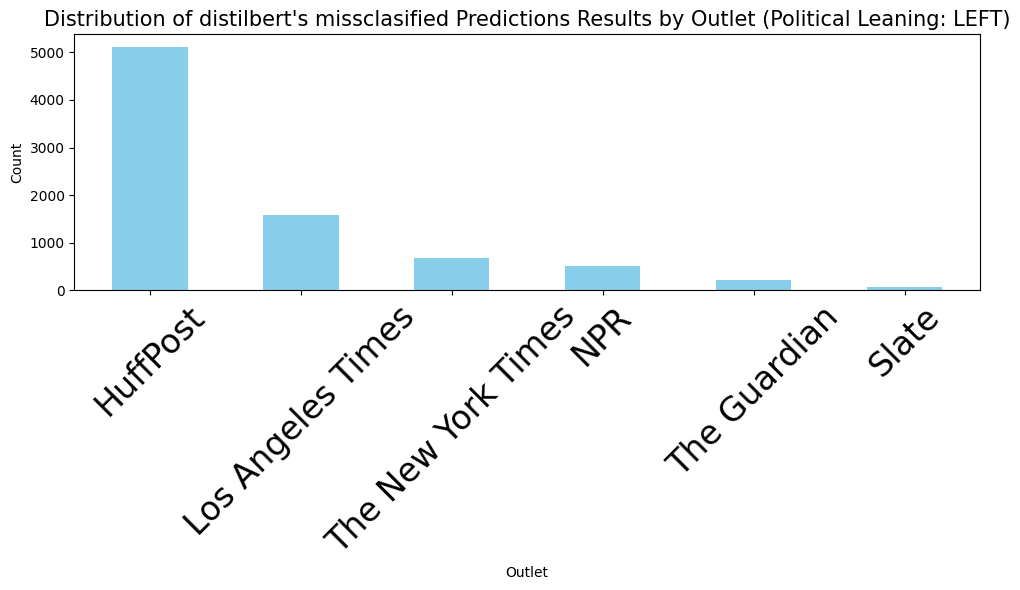

In [13]:
# Filter the DataFrame
filtered_df_left = df[(df['test_result'] == 'wrong') & (df['political_leaning'] == 'LEFT')]

# Count occurrences grouped by the 'outlet' column
outlet_counts = filtered_df_left['outlet'].value_counts()

# Plot the results
outlet_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Add titles and labels
plt.title("Distribution of distilbert's missclasified Predictions Results by Outlet (Political Leaning: LEFT)", fontsize=15)
plt.xlabel('Outlet' )
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=24)
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
print(filtered_df_left[filtered_df_left['outlet'] == 'HuffPost'].iloc[0])
text = filtered_df_left[filtered_df_left['outlet'] == 'HuffPost'].iloc[0, 5]
print(text)

id                                                             3971207
date_publish                                       2017-07-01 00:46:52
outlet                                                        HuffPost
headline             Friday Talking Points -- You Crazy, Lunatic, 7...
lead                 That's a doozy of a subheading, but we felt it...
body                 That's a doozy of a subheading, but we felt it...
authors              Chris Weigant;Chris Weigant Is A Political Com...
domain                                          www.huffingtonpost.com
url                  http://www.huffingtonpost.com/entry/friday-tal...
political_leaning                                                 LEFT
inference                                                    UNDEFINED
test_result                                                      wrong
Name: 134, dtype: object
That's a doozy of a subheading, but we felt it was completely appropriate this week. It is a direct quote, from conservativ

In [3]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoConfig,
    DistilBertModel,
    DistilBertTokenizer,
    
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from torch.utils.data import DataLoader

import torch
import numpy as np
import numpy as np

# Load model and tokenizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
from utils.distilbert_nn import *

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

device


'cuda'

In [15]:
from peft import LoraConfig, get_peft_model

model_checkpoint = 'distilbert-base-uncased'

#Define label maps
id2label = {0:"UNDEFINED" ,1:"LEFT",2:"RIGHT",3:"CENTER"}
label2id = {"UNDEFINED": 0, "LEFT": 1, "RIGHT": 2, "CENTER": 3}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=4, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix=True)

# Recreate LoRA configuration
peft_config = LoraConfig(
    task_type="SEQ_CLS", r=4, lora_alpha=32, lora_dropout=0.01, target_modules=["q_lin"]
)

# Apply LoRA configuration
base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4, id2label=id2label, label2id=label2id)
model = get_peft_model(base_model, peft_config)

# Load LoRA adapter weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(r"C:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\models\LORA_distilBERT_BODY_2017_1.pth", map_location=device), strict=False)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4080\666588028.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.01, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=7

In [18]:
# Initialize a list to store the predictions
predictions_list = []

# Make predictions for each row in the dataset
model.eval()
with torch.no_grad():
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    logits = model(inputs).logits
    predictions = torch.argmax(logits, dim=1).item()  # Get the predicted class label
    predictions_list.append(predictions)

# Add the predictions as a new column to the dataset

In [19]:
print(predictions_list)

[0]


# **Analysis for the right misclassified labels**

In [22]:
#print(filtered_df_left[filtered_df_left['outlet']=='HuffPost'].iloc[0,5])

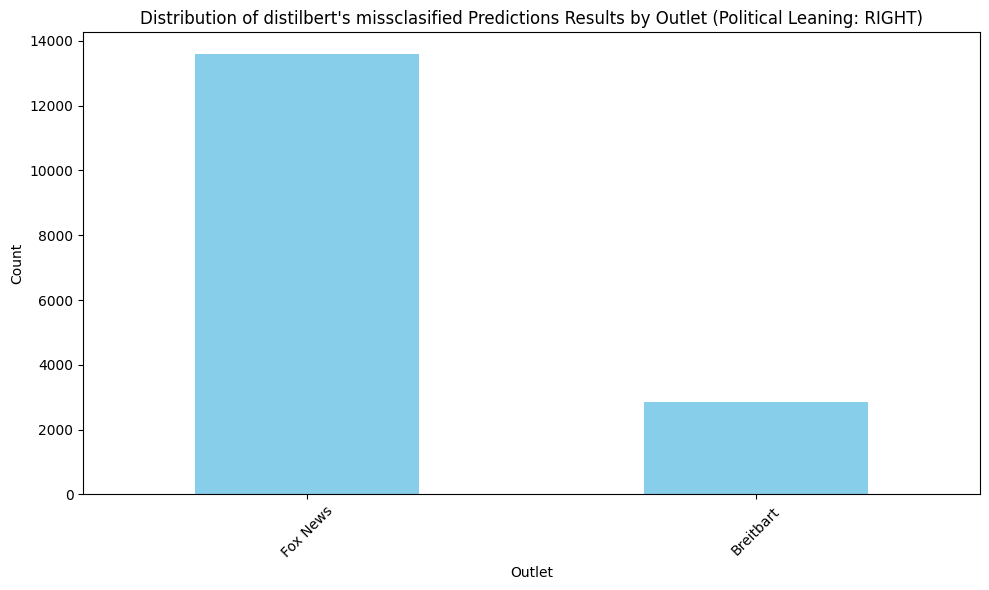

In [14]:
# Filter the DataFrame
filtered_df_right = df[(df['test_result'] == 'wrong') & (df['political_leaning'] == 'RIGHT')]

# Count occurrences grouped by the 'outlet' column
outlet_counts = filtered_df_right['outlet'].value_counts()

# Plot the results
outlet_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Add titles and labels
plt.title("Distribution of distilbert's missclasified Predictions Results by Outlet (Political Leaning: RIGHT)")
plt.xlabel('Outlet')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()